<a href="https://colab.research.google.com/github/Tunji17/huggingface-tasks/blob/main/Supervised_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supervised Finetune of [HuggingFaceTB/SmolLM2-360M](HuggingFaceTB/SmolLM2-360M) using COT dataset [HuggingFaceTB/smoltalk](https://huggingface.co/datasets/HuggingFaceTB/smoltalk)

In [33]:
%pip install transformers torch datasets trl wandb --quiet

In [34]:
from huggingface_hub import notebook_login

notebook_login()

In [35]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 2nji (_2nji) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [36]:
from datasets import load_dataset, DatasetDict

datasets = load_dataset("HuggingFaceTB/smoltalk", "numina-cot-100k")

# Get a sample for validation
val_dataset = datasets["test"].train_test_split(test_size=0.1, seed=42)

datasets = DatasetDict({
    "train": datasets["train"],
    "test": val_dataset["train"],
    "validation": val_dataset["test"]
})

print(datasets)

DatasetDict({
    train: Dataset({
        features: ['source', 'messages'],
        num_rows: 106147
    })
    test: Dataset({
        features: ['source', 'messages'],
        num_rows: 5028
    })
    validation: Dataset({
        features: ['source', 'messages'],
        num_rows: 559
    })
})


In [37]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

checkpoint = "HuggingFaceTB/SmolLM2-360M"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)


In [38]:
inputs = tokenizer.encode("Ben twice chooses a random integer between 1 and 60, inclusive. What is the probability that at least one of the numbers Ben chooses is a multiple of 4?", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Ben twice chooses a random integer between 1 and 60, inclusive. What is the probability that at least one of the numbers Ben chooses is a multiple of 4?

A. 1/2
B. 1/3
C. 1


In [50]:
chat_template = "{% for message in messages %}{% if loop.first and messages[0]['role'] != 'system' %}{{ '<|im_start|>system\nYou are a helpful AI assistant named Numina SmolLM, SFT by 2nji <|im_end|>\n' }}{% endif %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

# Set the chat template for the tokenizer
tokenizer.chat_template = chat_template

tokenizer.pad_token = tokenizer.eos_token

In [46]:
from trl import SFTConfig, SFTTrainer

# Configure trainer
training_args = SFTConfig(
    run_name="sft_numina-cot_SmolLM2-360M",
    output_dir="./sft_output",
    max_steps=1000,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    logging_steps=10,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=50,
    report_to=["wandb"]
)

In [47]:
# Initialize trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["test"],
    processing_class=tokenizer,
)

Applying chat template to train dataset:   0%|          | 0/106147 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/106147 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/106147 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/5028 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5028 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5028 [00:00<?, ? examples/s]

In [48]:
wandb.init(project="huggingface", name="sft_numina-cot_SmolLM2-360M")

wandb.watch(model, log="all")

In [51]:

# Start training
trainer.train()

Step,Training Loss,Validation Loss
50,0.789200,0.858635
100,0.804300,0.838511
150,0.834500,0.827041
200,0.925300,0.819905
250,0.803800,0.813244
300,0.809100,0.808691
350,0.807100,0.803598
400,0.789200,0.800214
450,0.880400,0.795913
500,0.735100,0.793366


Step,Training Loss,Validation Loss
50,0.789200,0.858635
100,0.804300,0.838511
150,0.834500,0.827041
200,0.925300,0.819905
250,0.803800,0.813244
300,0.809100,0.808691
350,0.807100,0.803598
400,0.789200,0.800214
450,0.880400,0.795913
500,0.735100,0.793366


TrainOutput(global_step=1000, training_loss=0.7979624919891357, metrics={'train_runtime': 5936.7896, 'train_samples_per_second': 0.674, 'train_steps_per_second': 0.168, 'total_flos': 6341693959180800.0, 'train_loss': 0.7979624919891357})

In [52]:
%pip install matplotlib --quiet

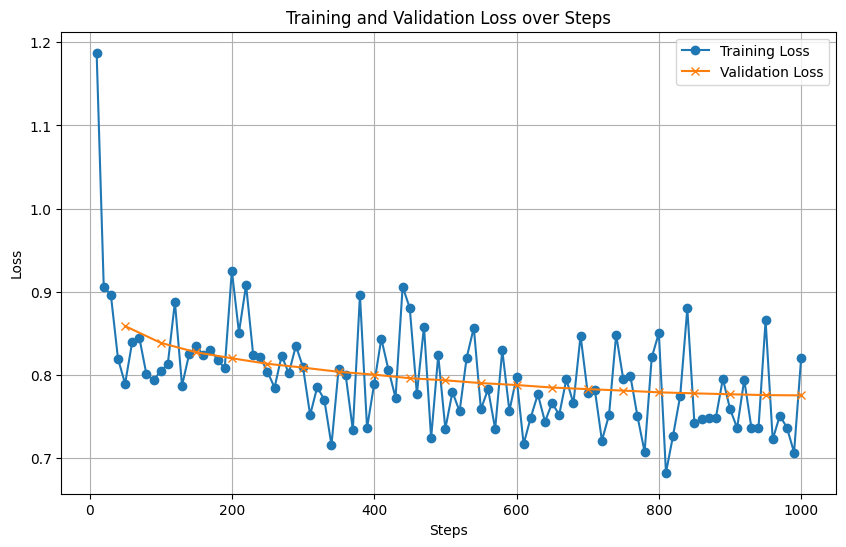

In [53]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer.
log_history = trainer.state.log_history

# Initialize lists to hold your metrics.
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

# Loop through the log history and separate training and validation entries.
for log in log_history:
    # Check if this log entry corresponds to training (has "loss")
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])

    # Check if this log entry corresponds to evaluation (has "eval_loss")
    if "eval_loss" in log and "step" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

# Plot training loss.
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker="o")

# Plot validation loss if available.
if eval_steps and eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="x")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 2.17


In [65]:
# Now push the model to the Hub
trainer.push_to_hub("Saving model and tokenizer")

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/2nji/sft_output/commit/325e970fcecbcbd0f5f0a5e67509022f6bee7f1a', commit_message='Saving model and tokenizer', commit_description='', oid='325e970fcecbcbd0f5f0a5e67509022f6bee7f1a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/2nji/sft_output', endpoint='https://huggingface.co', repo_type='model', repo_id='2nji/sft_output'), pr_revision=None, pr_num=None)

In [66]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

checkpoint = "2nji/sft_numina-cot_SmolLM2-360M"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

tokenizer_config.json:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [67]:
inputs = tokenizer.encode("Ben twice chooses a random integer between 1 and 60, inclusive. What is the probability that at least one of the numbers Ben chooses is a multiple of 4?", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Ben twice chooses a random integer between 1 and 60, inclusive. What is the probability that at least one of the numbers Ben chooses is a multiple of 4?

A: $\frac{1}{2}$

B: $\frac{1}{
